### Goal : Decompose time-series data into three terms: trend, period & random


Resources/Bibliograpy:
- [Basic Fourier transform](http://www.phys.nsu.ru/cherk/fft.pdf)
- [Fourier Decomposition Analysis for non-lin
ear & non-stationary data](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0871)
- [Empirical Mode Decomposition (EMD)](https://srcole.github.io/2016/01/18/emd/)
- [Ensemble Empirical Mode Decomposition (EEMD)](https://www.worldscientific.com/doi/abs/10.1142/S1793536909000047)
- [EEMD + LSTM](https://link.springer.com/article/10.1007/s11269-019-02345-1)

In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data 
csv_index   = 6
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_basic    = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
synth_name  = "soil"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_soil     = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)

time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.70 seconds


In [3]:
# Preprocess data
df_basic = downsample_dataframe(df_basic, night_method='basic', clip_method='universal')
df_soil  = downsample_dataframe(df_soil, night_method='basic', clip_method='universal')

(242810, 8)
(174047, 8)


In [4]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [5]:
df_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [6]:
df_basic.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,371.108434,167.144578,7.353815,0.0,0.999990,1.0,1.0,759.108434
2015-01-02 00:00:00-05:00,376.153226,169.137097,7.321774,0.0,0.999975,1.0,1.0,760.262097
2015-01-03 00:00:00-05:00,378.401606,169.971888,7.284739,0.0,0.999960,1.0,1.0,761.309237
2015-01-04 00:00:00-05:00,380.956000,170.872000,7.244400,0.0,0.999945,1.0,1.0,762.352000
2015-01-05 00:00:00-05:00,383.800797,171.888446,7.210757,0.0,0.999930,1.0,1.0,763.390438


In [7]:
df_basic.tail()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2019-12-27 00:00:00-05:00,351.105691,163.593496,7.540244,0.0,0.971325,1.0,1.0,753.723577
2019-12-28 00:00:00-05:00,354.575510,165.081633,7.493469,0.0,0.971310,1.0,1.0,754.873469
2019-12-29 00:00:00-05:00,355.426829,165.353659,7.469512,0.0,0.971295,1.0,1.0,755.939024
2019-12-30 00:00:00-05:00,356.607287,165.769231,7.423887,0.0,0.971280,1.0,1.0,757.000000
2019-12-31 00:00:00-05:00,358.000000,166.245968,7.393952,0.0,0.971270,1.0,1.0,758.056452


In [7]:
df_soil.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,389.735632,174.264368,7.300383,0.0,0.999987,0.996937,1.0,752.547893
2015-01-02 00:00:00-05:00,393.765385,176.219231,7.267308,0.0,0.999965,0.994924,1.0,753.623077
2015-01-03 00:00:00-05:00,395.068966,177.026820,7.230268,0.0,0.999943,0.992911,1.0,754.647510
2015-01-04 00:00:00-05:00,396.614504,177.896947,7.190458,0.0,0.999919,0.990898,1.0,755.667939
2015-01-05 00:00:00-05:00,398.501901,178.882129,7.155894,0.0,0.999895,0.988885,1.0,756.684411


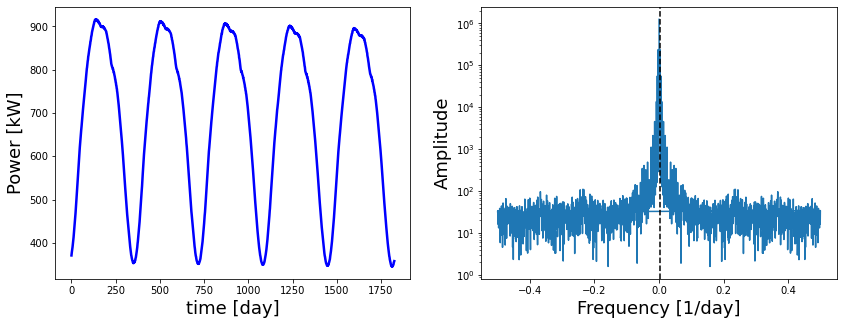

In [8]:
# Manually obtain the frequencies (similar to fftpack.fftfreq)
#L = len(df["Power"].to_numpy()) # length of signal
#T = 1 # [day] # sampling period
#Fs = 1/T # [1/day] # sampling frequency
#freq = Fs*np.arange(L/2)/L
# =========================================================================

power_fft = fftpack.fft(df_basic["Power"].to_numpy())
sample_freq = fftpack.fftfreq(df_basic["Power"].to_numpy().size, d=1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)

ax[1].plot(sample_freq, np.abs(power_fft)) # plot freq domain
ax[1].axvline(1/365, ls="--", color="k") # this is the year frequency

ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Frequency [1/day]", fontsize=18)
#ax[1].set_xlim([0, 0.1])
#ax[1].set_xscale("log")
ax[1].set_yscale("log")

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

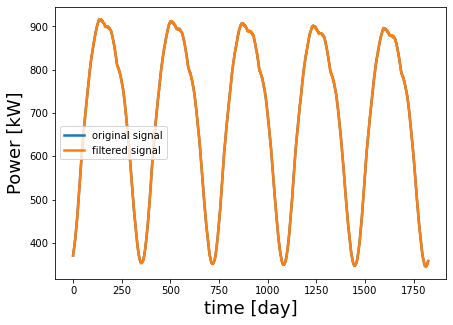

In [10]:
# remove all the hight frequencies
high_freq_fft = power_fft.copy()
#high_freq_fft[np.abs(sample_freq) > 0.01] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5)
ax.plot(filtered_sig, label="filtered signal", lw=2.5)
ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

### Plot FT for basic and soiling for (a) daily frequency

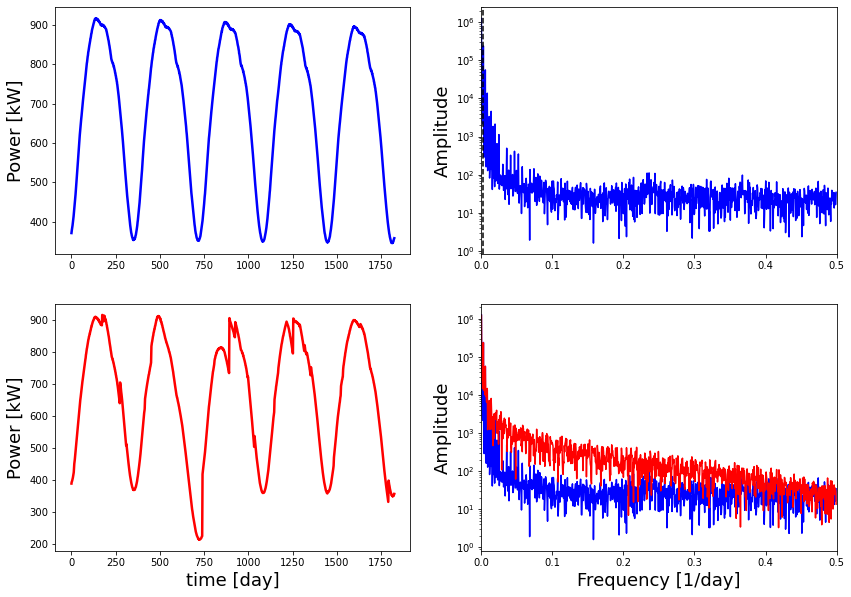

In [41]:
size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[0, 1].axvline(1/365, ls="--", color="k") # this is the year frequency
ax[1, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain

ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.5])
ax[1, 1].set_xlim([0, 0.5])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

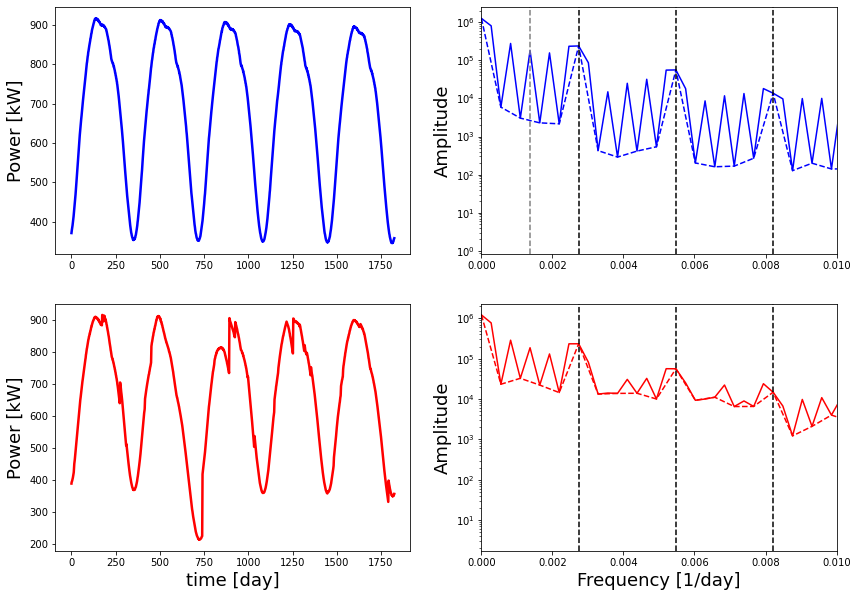

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 1826*2
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

ax[0, 1].axvline(1./(2*365), color="grey", ls="--")

for i in range(3):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency


ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.01])
ax[1, 1].set_xlim([0, 0.01])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

In [29]:
size              = 10000
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

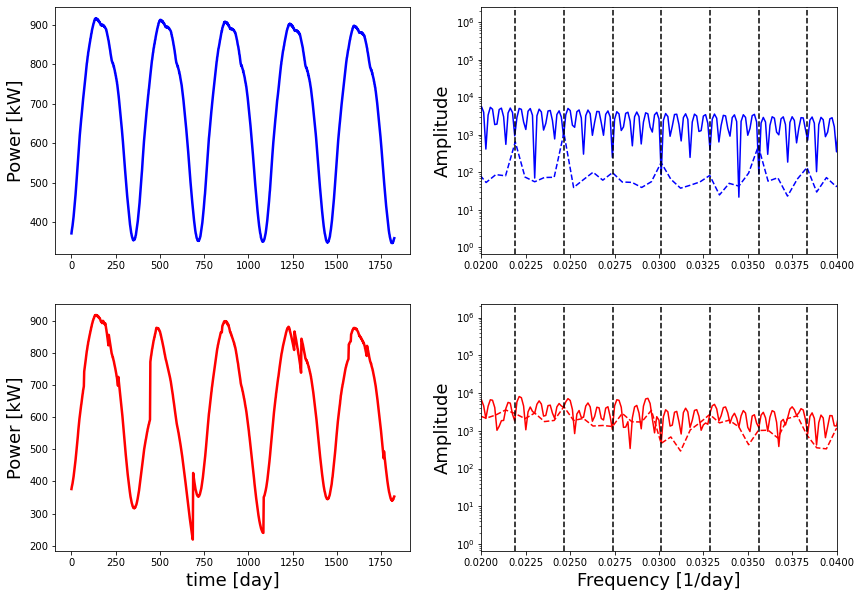

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 8000#df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

for i in range(15):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.02, 0.04])
ax[1, 1].set_xlim([0.02, 0.04])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

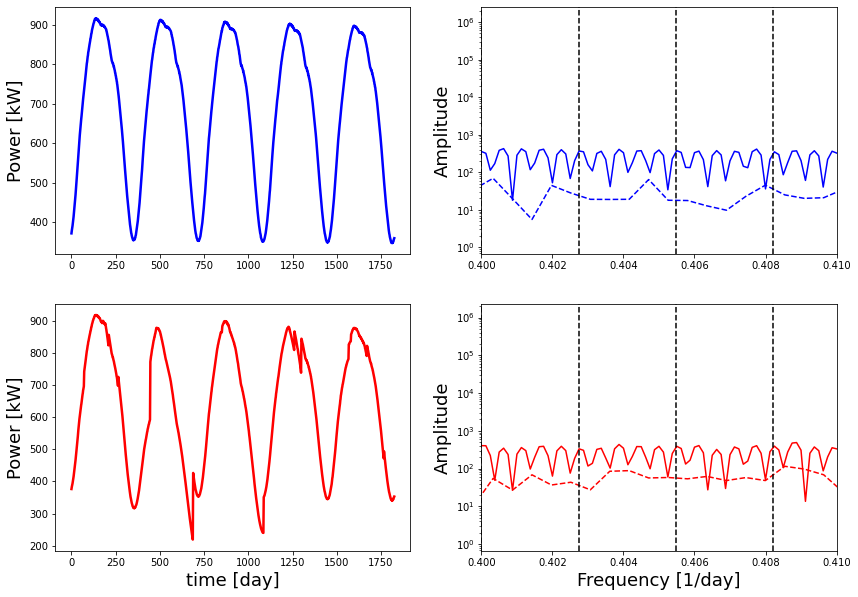

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 8000#df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

for i in range(150):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.4, 0.41])
ax[1, 1].set_xlim([0.4, 0.41])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

**Filter out frequency 1/365 and all the corresponding harmonics**

In [52]:
test = np.arange(5, 15, 5)
print (test)
test = -test[::-1]
print (test)

[ 5 10]
[-10  -5]


/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 0.04)

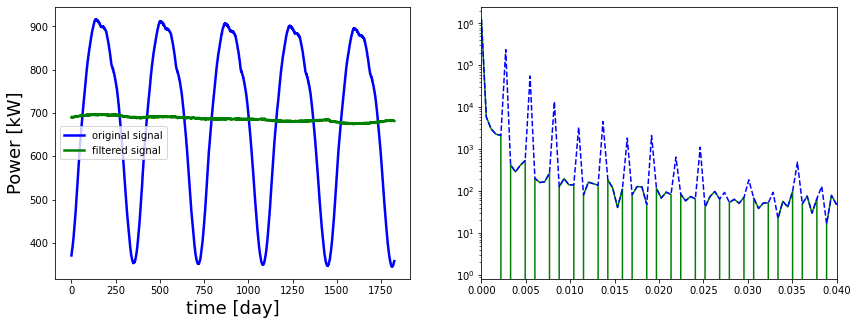

In [8]:
size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

high_freq_basic      = power_basic.copy()
pos                  = np.arange(5, 1000, 5)
high_freq_basic[pos] = 0
pos                  = -pos[::-1] # reverse array & make it negative
high_freq_basic[pos] = 0
filtered_sig         = fftpack.ifft(high_freq_basic)

ax[0].plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax[0].plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")

ax[1].plot(sample_freq_basic[0:int(1826/2)], np.abs(high_freq_basic[0:int(1826/2)]), color="green")
ax[1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
#ax[1].plot(sample_freq_basic[int(1826/2):], np.abs(high_freq_basic[int(1826/2):]), color="green")
#ax[1].plot(sample_freq_basic[int(size/2):], np.abs(power_basic[int(size/2):]), color="blue", ls="--") 

ax[0].legend(loc="best")
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)
ax[1].set_yscale("log")
ax[1].set_xlim([0, 0.04])

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, "'time' [days]")

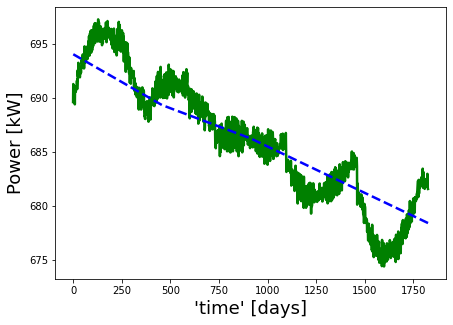

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

power_year = df_basic.resample("y").mean().Power.to_numpy()
x_year     = np.linspace(1, 1826, 5)

ax.plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")
ax.plot(x_year, power_year, color="blue", ls="--", lw=2.5)
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("'time' [days]", fontsize=18)

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Frequency [1/day]')

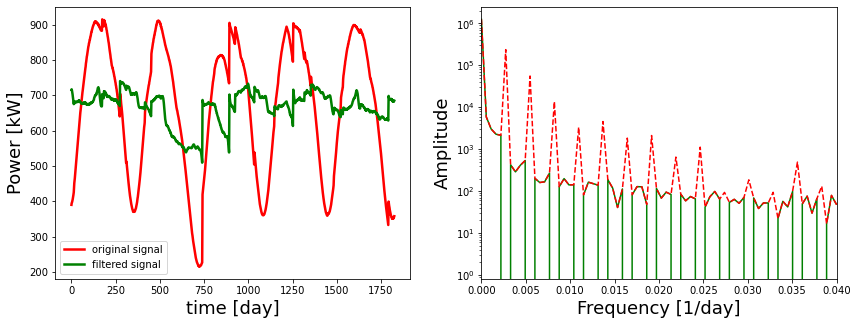

In [70]:
## Filter out frequency 1/365 and all the corresponding harmonics
size             = df_soil["Power"].to_numpy().size
power_soil       = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil = fftpack.fftfreq(size, d=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

high_freq_soil      = power_soil.copy()
pos                 = np.arange(5, 100, 5)
high_freq_soil[pos] = 0
pos                 = -pos[::-1] # reverse array & make it negative
high_freq_soil[pos] = 0
filtered_sig        = fftpack.ifft(high_freq_soil)

ax[0].plot(df_soil["Power"].to_numpy(), label="original signal", lw=2.5, color="red")
ax[0].plot(fftpack.ifft(high_freq_soil), label="filtered signal", lw=2.5, color="green")

ax[1].plot(sample_freq_basic[0:int(1826/2)], np.abs(high_freq_basic[0:int(1826/2)]), color="green")
ax[1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="red", ls="--")
#ax[1].plot(sample_freq_soil[int(1826/2):], np.abs(high_freq_soil[int(1826/2):]), color="green")#
#ax[1].plot(sample_freq_soil[int(size/2):], np.abs(power_soil[int(size/2):]), color="red", ls="--")

ax[0].legend(loc="best")
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)
ax[1].set_yscale("log")
ax[1].set_xlim([0, 0.04])
ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Frequency [1/day]", fontsize=18)

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, "'time' [days]")

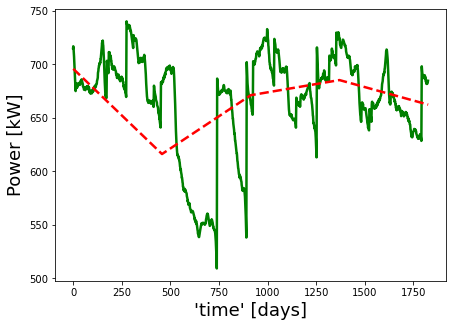

In [85]:
fig, ax = plt.subplots(figsize=(7, 5))

power_year = df_soil.resample("y").mean().Power.to_numpy()
x_year     = np.linspace(1, 1826, 5)

ax.plot(fftpack.ifft(high_freq_soil), label="filtered signal", lw=2.5, color="green")
ax.plot(x_year, power_year, color="red", ls="--", lw=2.5)
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("'time' [days]", fontsize=18)

### Plot FT for basic and soiling for (a) hourly frequency

### Ensemble Empirical Mode Decomposition

In [8]:
from PyEMD import EEMD

In [10]:
eemd = EEMD()

In [11]:
days  = np.arange(1, 1827, 1)
eIMFs = eemd.eemd(df_basic.Power.to_numpy(), days)
nIMFs = eIMFs.shape[0]

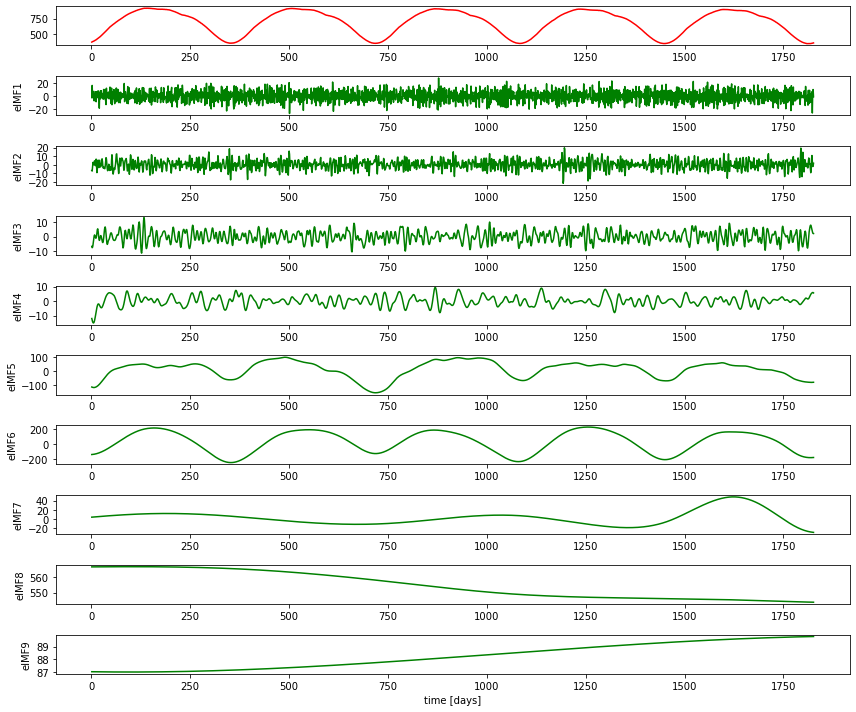

In [61]:
plt.figure(figsize=(12, 10))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(days, df_basic.Power.to_numpy(), "red")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(days, eIMFs[n], 'g')
    plt.ylabel("eIMF%i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
plt.xlabel("time [days]")
plt.tight_layout()

In [63]:
eemd = EEMD()
emd  = eemd.EMD
emd.extrema_detection="parabol"
days  = np.arange(1, 1827, 1)
eIMFs = eemd.eemd(df_basic.Power.to_numpy(), days)
nIMFs = eIMFs.shape[0]

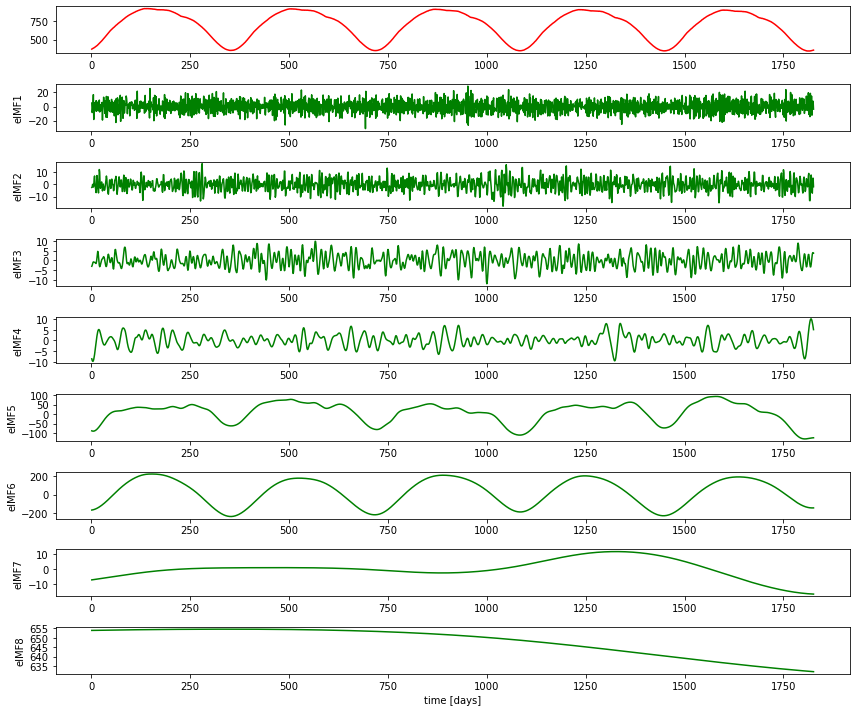

In [64]:
plt.figure(figsize=(12, 10))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(days, df_basic.Power.to_numpy(), "red")

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(days, eIMFs[n], 'g')
    plt.ylabel("eIMF%i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
plt.xlabel("time [days]")
plt.tight_layout()

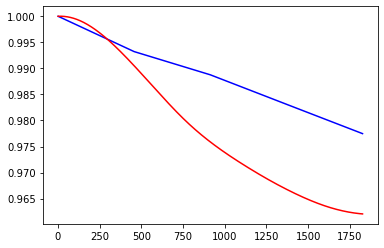

In [43]:
fig, ax = plt.subplots()
df_years = df_basic.resample("y").mean()
years    = [1., days[-1]/4, days[-1]/4*2, days[-1]/4*3, days[-1]/4*4]
ax.plot(years, df_years.Power.to_numpy()/df_years.Power.to_numpy()[0], color="blue")
ax.plot(days, eIMFs[-1]/eIMFs[-1][0], color="red")

### Daily calculated Performance Loss Rate

In [8]:
from datetime import datetime

In [34]:
years = np.unique(df_basic.index.year)
PLR   = []

for i in range(len(years[:-1])):
    df_year = df_basic.iloc[df_basic.index.year==years[i]]
    for j in range(df_year.Power.to_numpy().size):
        power_yt2 = df_basic.loc[(df_basic.index.year==years[i+1]) & (df_basic.index.day==df_year.index[j].day) & (df_basic.index.month==df_year.index[j].month)].Power
        try:
            _PLR = (power_yt2.values-df_year.iloc[j].Power)/df_year.iloc[j].Power # divide better by the median of year
            PLR.append(_PLR[0]*100)
        except:
            PLR.append(np.NaN)
            print (years[i], df_year.index[j].day, df_year.index[j].month)
PLR = np.array(PLR, dtype=np.float)

2016 29 2


In [35]:
# Theoretical PLR
years  = np.unique(df_basic.index.year)
PLR_th = []

for i in range(len(years[:-1])):
    df_year = df_basic.iloc[df_basic.index.year==years[i]]
    
    for j in range(df_year.Degradation.to_numpy().size):
        DF      = df_basic.loc[(df_basic.index.year==years[i+1]) & (df_basic.index.day==df_year.index[j].day) & (df_basic.index.month==df_year.index[j].month)].Degradation
        #print (years[i], df_year.index[j].day, df_year.index[j].month, DF.values[0], df_year.iloc[j].Degradation)
        try:
            _PLR_th = (DF.values[0]-df_year.iloc[j].Degradation)*100
            PLR_th.append(_PLR_th)
        except:
            PLR_th.append(np.NaN)
            print (PLR_th[j], years[i], df_year.index[j].day, df_year.index[j].month)
PLR_th = np.array(PLR_th, dtype=np.float)

-0.5763719230733155 2016 29 2


In [37]:
# add two columns with PLR & PLR_th
first_year    = np.ones(365)
first_year[:] = np.NaN
PLR           = np.concatenate((first_year, PLR))
PLR_th        = np.concatenate((first_year, PLR_th))

df_basic["PLR"]    = PLR
df_basic["PLR_th"] = PLR_th

(1461,)
(1826,) 1826


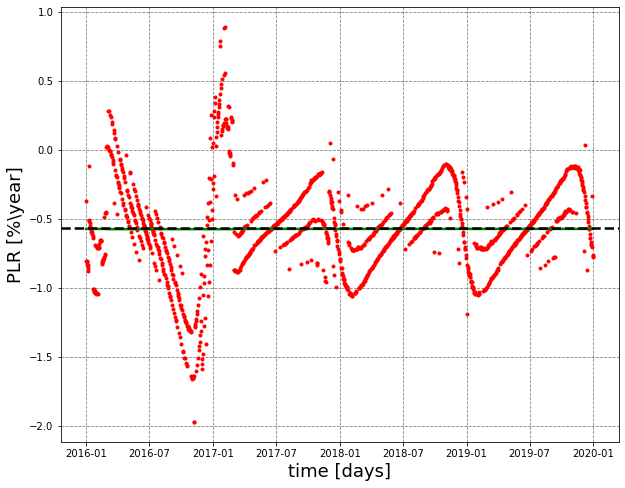

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_basic.PLR, "r.")
ax.plot(df_basic.PLR_th, ls="-", color="green", lw=2.5)

_PLR =df_basic.PLR.to_numpy()[np.logical_not(np.isnan(df_basic.PLR.to_numpy()))] # remove NaN values
ax.axhline(np.median(_PLR), lw=2.5, color="k", ls="--")

ax.set_xlabel("time [days]", fontsize=18)
ax.set_ylabel("PLR [%\year]", fontsize=18)
ax.grid(which="both", ls="--", color="k", alpha=0.5)

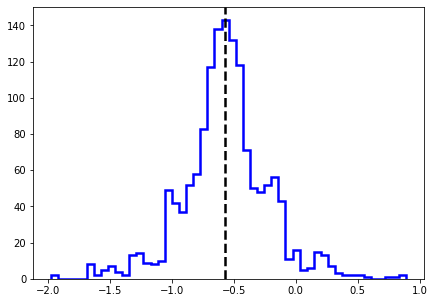

In [48]:
fig, ax = plt.subplots(figsize=(7, 5))
_, _, _ = ax.hist(df_basic.PLR.to_numpy(), bins=50, histtype="step", color="blue", linewidth=2.5)
_PLR =df_basic.PLR.to_numpy()[np.logical_not(np.isnan(df_basic.PLR.to_numpy()))] # remove NaN values
ax.axvline(np.median(_PLR), lw=2.5, color="k", ls="--")

In [57]:
print ("%.2f" %(np.median(_PLR)))

_PLR_th = df_basic.PLR_th.to_numpy()[np.logical_not(np.isnan(df_basic.PLR_th.to_numpy()))]
print (df_basic.PLR_th.to_numpy()[365])

-0.57
-0.5745403225808965


In [59]:
np.unique(_PLR_th)

array([-0.57649374, -0.57648163, -0.57646434, ..., -0.57442065,
       -0.57441951, -0.574     ])

In [62]:
from sklearn.metrics import mean_squared_error

msq = mean_squared_error(_PLR_th, _PLR)
np.sqrt(msq)*100

34.53933209224829